# Movie Rating Prediction Notebook

In [46]:
# Import required libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as pxnbformat
import plotly.graph_objects as go
import plotly.io as pio
import nbformat
from plotly.subplots import make_subplots
from IPython.display import display, HTML, Image
from importlib import reload
from matplotlib_venn import venn2

# Configure plotting settings
plt.style.use('default')  # Using default matplotlib style
sns.set_theme()  # Set seaborn theme properly
plt.rcParams['figure.figsize'] = [12, 6]
pio.renderers.default = "notebook"

# Add the backend directory to Python path
current_dir = os.path.dirname(os.path.abspath(''))
backend_dir = os.path.join(current_dir, 'backend')
if backend_dir not in sys.path:
    sys.path.append(backend_dir)

# Import and reload predictor module to get latest changes
try:
    import predictor
    reload(predictor)
    from predictor import MovieRatingPredictor
except ImportError as e:
    print(f"Import Error: {e}")
    print(f"Searching in paths: {sys.path}")
    sys.exit(1)

# Initialize predictor
predictor = MovieRatingPredictor()

## Dataset Analysis

First, let's analyze our datasets using the `describe()` method from our predictor class.

In [47]:
# Get dataset description
description = predictor.describe()

if description:
    print("=== Dataset Statistics ===")
    print("-" * 50)
    for dataset_name, stats in description['dataset_statistics'].items():
        print(f"\n{stats['name']}:")
        print(f"Number of rows: {stats['rows']:,}")
        print(f"Number of columns: {stats['columns']}")
        print(f"Size in MB: {stats['size_mb']:.2f}")
        
    print("\n=== Data Sources ===")
    print("-" * 50)
    for source_name, info in description['data_sources'].items():
        print(f"\n{info['source']}:")
        print(f"Description: {info['description']}")
        print(f"URL: {info['url']}")
else:
    print("Error: Could not retrieve dataset description")

=== Dataset Statistics ===
--------------------------------------------------

IMDb Movies:
Number of rows: 5,043
Number of columns: 28
Size in MB: 1.42

TMDB Movies:
Number of rows: 45,466
Number of columns: 24
Size in MB: 32.85

=== Data Sources ===
--------------------------------------------------

IMDb Movies Dataset:
Description: Contains detailed movie information including ratings and metadata
URL: https://www.kaggle.com/code/aditimulye/imdb-5000-movie-dataset-analysis

TMDB 45K Movies Dataset:
Description: Contains comprehensive movie information including budget, revenue, and detailed metadata
URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data?select=movies_metadata.csv


In [48]:
# Debug: Print the structure of the description dictionary in a readable format
if description:
    print("=== Description Dictionary Structure ===")
    print("\nAvailable keys:", ", ".join(description.keys()))
    
    def print_nested_dict(d, indent=0):
        for key, value in d.items():
            if isinstance(value, dict):
                print("\n" + " " * indent + f"{key}:")
                print_nested_dict(value, indent + 4)
            else:
                if isinstance(value, list):
                    print(" " * indent + f"{key}: [")
                    for item in value:
                        print(" " * (indent + 4) + f"- {item}")
                    print(" " * indent + "]")
                else:
                    wrapped_value = str(value)
                    if len(wrapped_value) > 80:
                        wrapped_value = wrapped_value[:77] + "..."
                    print(" " * indent + f"{key}: {wrapped_value}")
    
    for key in description:
        print(f"\n{'='*20} {key} {'='*20}")
        print_nested_dict(description[key])
        print()
else:
    print("No description data available")

=== Description Dictionary Structure ===

Available keys: dataset_statistics, data_sources, erd

==================== dataset_statistics ====================

imdb:
    name: IMDb Movies
    rows: 5043
    columns: 28
    size_mb: 1.4206352233886719

    null_counts:
        color: 19
        director_name: 104
        num_critic_for_reviews: 50
        duration: 15
        director_facebook_likes: 104
        actor_3_facebook_likes: 23
        actor_2_name: 13
        actor_1_facebook_likes: 7
        gross: 884
        genres: 0
        actor_1_name: 7
        movie_title: 0
        num_voted_users: 0
        cast_total_facebook_likes: 0
        actor_3_name: 23
        facenumber_in_poster: 13
        plot_keywords: 153
        movie_imdb_link: 0
        num_user_for_reviews: 21
        language: 12
        country: 5
        content_rating: 303
        budget: 492
        title_year: 108
        actor_2_facebook_likes: 13
        imdb_score: 0
        aspect_ratio: 329
        movi

### Null Value Analysis

Let's visualize the null values in both datasets to better understand our data quality.

In [49]:
# Configure plotly for notebook display
import plotly.io as pio
from IPython.display import display, HTML

# Create null value visualization for both datasets
def plot_null_values(dataset_info, title):
    if 'null_counts' not in dataset_info:
        print(f"No null value information found for {title}")
        return
        
    null_data = pd.Series(dataset_info['null_counts'])
    total_rows = dataset_info['rows']
    
    # Calculate percentage of null values
    null_data_pct = (null_data / total_rows * 100).round(2)
    null_data_pct = null_data_pct[null_data_pct > 0].sort_values(ascending=True)
    
    if len(null_data_pct) > 0:
        # Create the bar plot using plotly.graph_objects for more control
        fig = go.Figure()
        
        # Add bars for null counts
        fig.add_trace(go.Bar(
            x=null_data_pct.values,
            y=null_data_pct.index,
            orientation='h',
            name='Null Percentage',
            text=[f"{v:.1f}% ({null_data[i]:,} rows)" for i, v in null_data_pct.items()],
            textposition='auto',
        ))
        
        fig.update_layout(
            title=f'Null Values in {title} (Total Rows: {total_rows:,})',
            xaxis_title='Percentage of Null Values',
            yaxis_title='Column Name',
            height=max(400, len(null_data_pct)*30),
            showlegend=False,
            xaxis=dict(range=[0, 100]),  # Set x-axis from 0 to 100%
            template='plotly_white'  # Use a clean template
        )
        
        # Convert to HTML and display
        html_str = fig.to_html(include_plotlyjs='cdn', full_html=False)
        display(HTML(html_str))
    else:
        print(f"No null values found in {title}")

print("=== Null Value Analysis ===")
print("This analysis shows the percentage of missing values in each column.\n")

# Plot null values for both datasets
if description and 'dataset_statistics' in description:
    for dataset_name, dataset_info in description['dataset_statistics'].items():
        print(f"\nAnalyzing null values in {dataset_info['name']}...")
        plot_null_values(dataset_info, dataset_info.get('name', dataset_name))
else:
    print("Error: Dataset statistics not found in description")

=== Null Value Analysis ===
This analysis shows the percentage of missing values in each column.


Analyzing null values in IMDb Movies...



Analyzing null values in TMDB Movies...


## Entity Relationship Diagram (ERD)

This will help us understand:
- The main entities in our system
- Their attributes and relationships
- The cardinality between different entities
- Primary and foreign key relationships

=== Entity Relationship Diagram ===

This diagram shows the relationships between different entities in our database:
- Boxes represent entities
- Bold attributes are Primary Keys (PK)
- Italic attributes are Foreign Keys (FK)
- Lines show relationships between entities
- Numbers (1,N) show cardinality of relationships



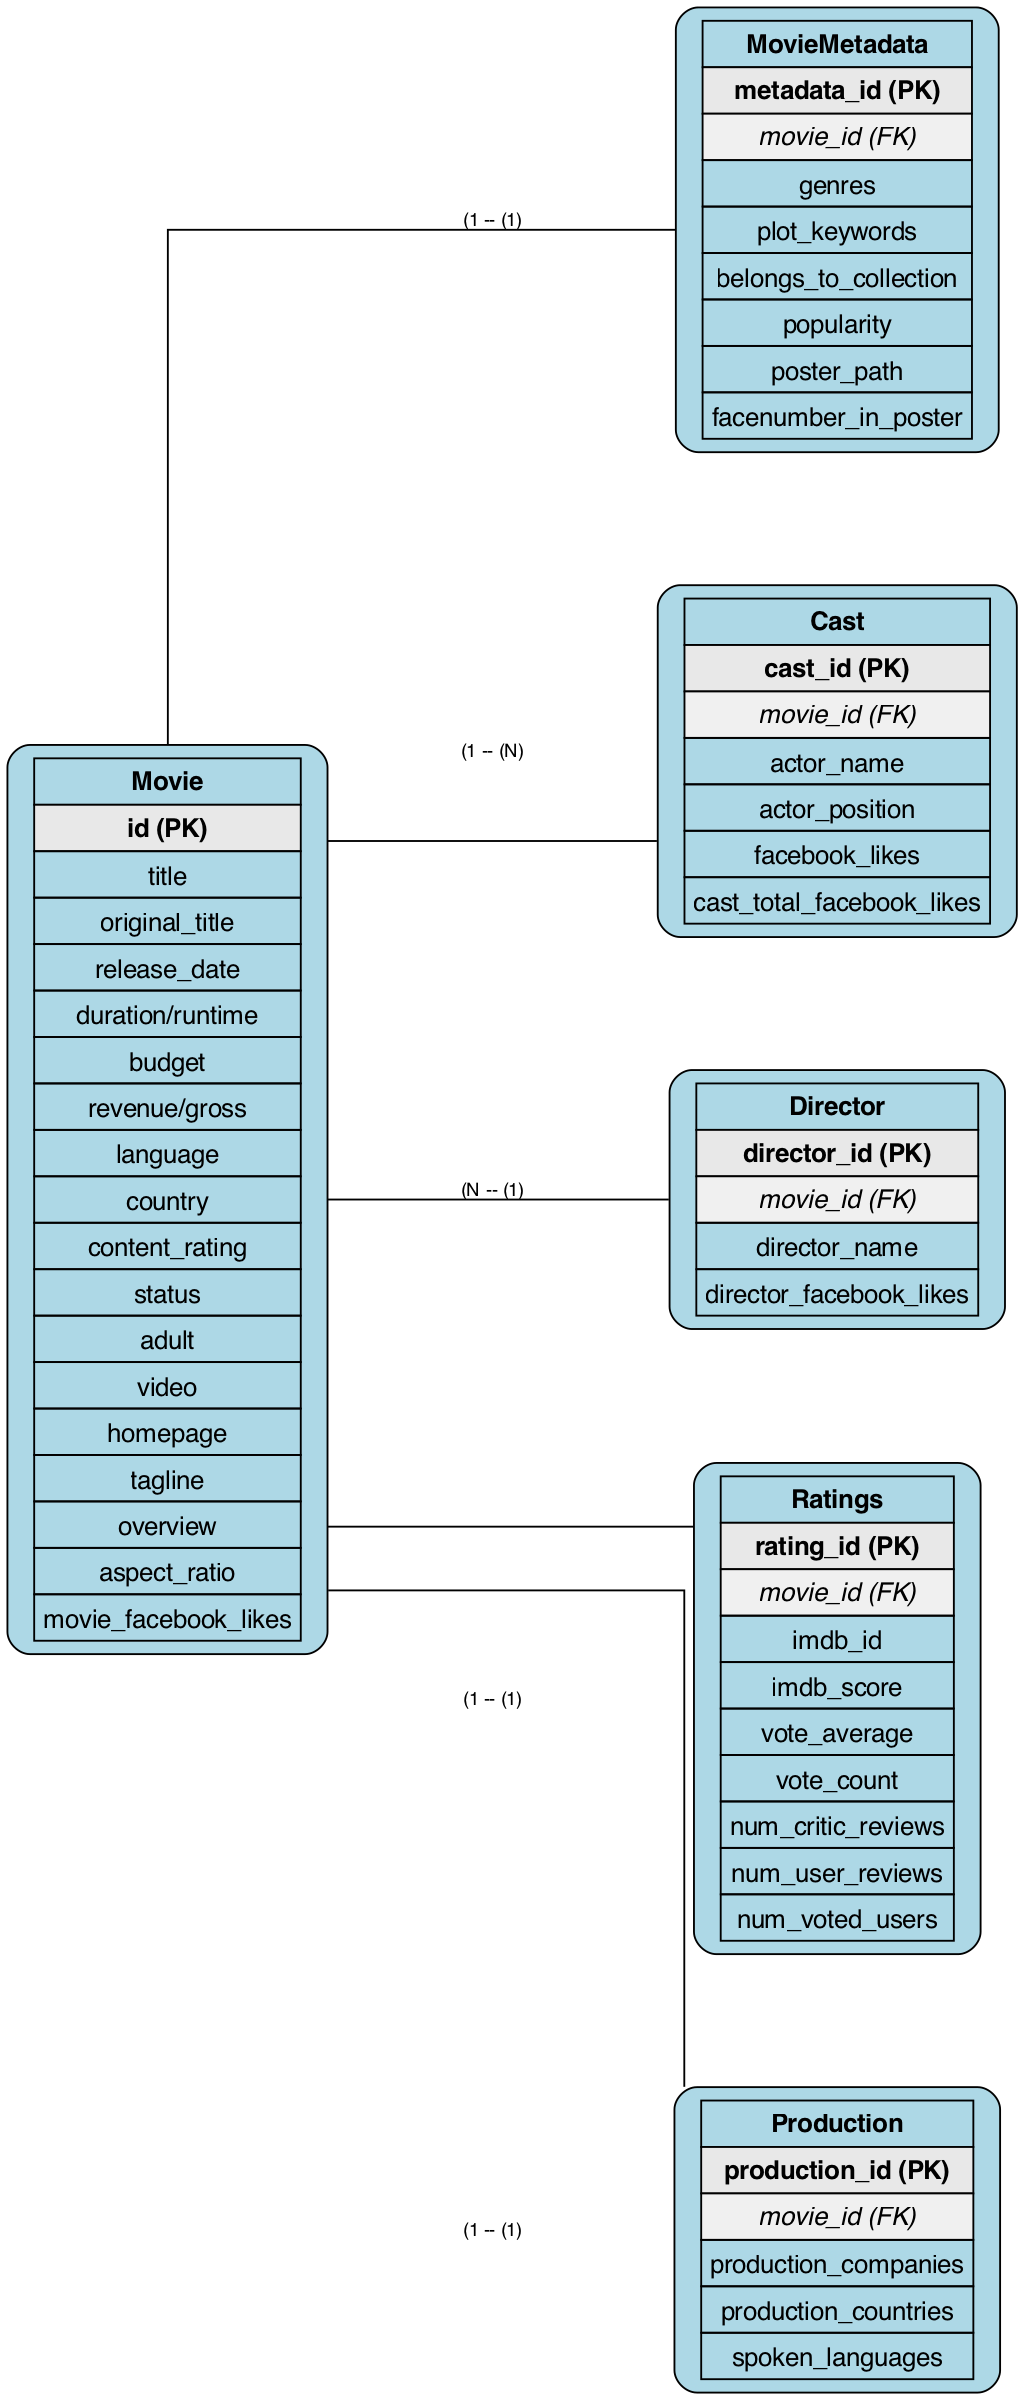

In [51]:
from graphviz import Digraph

def create_erd(erd_info):
    """Create ERD visualization using Graphviz"""
    if not erd_info:
        return "No ERD information available"
        
    # Create a new directed graph
    dot = Digraph(name='Movie Database ERD', 
                  comment='Entity Relationship Diagram for Movie Database',
                  format='png')
    
    # Graph attributes for better visualization
    dot.attr(rankdir='LR',  # Left to Right layout
            splines='ortho',  # Orthogonal lines
            nodesep='1.0',  # Horizontal separation between nodes
            ranksep='2.0',  # Vertical separation between ranks
            ratio='expand',  # Expand to fill available space
            size='11,8')    # Set wider than tall aspect ratio
    
    # Node attributes
    dot.attr('node', shape='box', 
            style='rounded,filled', 
            fillcolor='lightblue',
            fontname='Helvetica',
            width='0', height='0',  # Minimize node size
            margin='0.2,0.1')
    
    # Edge attributes
    dot.attr('edge', fontname='Helvetica',
            fontsize='10',
            len='2.0')
    
    # Add entities with their attributes
    for entity_name, entity_info in erd_info['entities'].items():
        # Create HTML-like label for better formatting
        label = f'<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="4">\n'
        # Entity name in the header
        label += f'<TR><TD PORT="header" BGCOLOR="#ADD8E6"><B>{entity_name}</B></TD></TR>\n'
        # Attributes
        for attr in entity_info['attributes']:
            # Highlight primary and foreign keys
            if '(PK)' in attr:
                label += f'<TR><TD PORT="{attr}" BGCOLOR="#E8E8E8" HEIGHT="22"><B>{attr}</B></TD></TR>\n'
            elif '(FK)' in attr:
                label += f'<TR><TD PORT="{attr}" BGCOLOR="#F0F0F0" HEIGHT="22"><I>{attr}</I></TD></TR>\n'
            else:
                label += f'<TR><TD PORT="{attr}" HEIGHT="22">{attr}</TD></TR>\n'
        label += '</TABLE>>'
        
        dot.node(entity_name, label=label)
    
    # Add relationships
    for rel in erd_info['relationships']:
        entity1, cardinality = rel.split(' -- ')
        entity1 = entity1.strip('()')
        entity2 = cardinality.strip('()').split()[1]
        card_type = cardinality.split()[0]
        
        # Create edge with cardinality label
        dot.edge(entity1.split()[0], entity2,
                label=f'{entity1.split()[1]} -- {card_type}',
                dir='both',
                arrowhead='crow' if card_type == 'N' else 'none',
                arrowtail='none')
    
    return dot

if description and 'erd' in description:
    print("=== Entity Relationship Diagram ===")
    print("\nThis diagram shows the relationships between different entities in our database:")
    print("- Boxes represent entities")
    print("- Bold attributes are Primary Keys (PK)")
    print("- Italic attributes are Foreign Keys (FK)")
    print("- Lines show relationships between entities")
    print("- Numbers (1,N) show cardinality of relationships\n")
    
    # Create and display ERD
    erd = create_erd(description['erd'])
    if isinstance(erd, str):
        print(erd)
    else:
        # Save in analysis directory
        analysis_dir = os.path.join(current_dir, 'analysis')
        os.makedirs(analysis_dir, exist_ok=True)
        erd_path = os.path.join(analysis_dir, 'movie_erd')

        # Render with higher DPI for better quality and landscape orientation
        erd.attr(dpi='300')
        erd.render(erd_path, format='png', cleanup=True)
        
        # Display the generated ERD
        display(Image(filename=f"{erd_path}.png"))
else:
    print("Error: ERD information not found in description")